In [90]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [91]:
movie_data=pd.read_csv('moviereviews_train.tsv',sep='\t')

In [92]:
# see the first 10 rows (header = head)
movie_data.head(10)
#We see 0 = False (bad review), 1 = True (good review)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
5,8196_8,1,I dont know why people think this is such a ba...
6,7166_2,0,"This movie could have been very good, but come..."
7,10633_1,0,I watched this video at a friend's house. I'm ...
8,319_1,0,"A friend of mine bought this film for £1, and ..."
9,8713_10,1,<br /><br />This movie is full of references. ...


In [93]:
movie_data.shape

(25000, 3)

In [94]:
positive_movie_data = movie_data[(movie_data['sentiment'] == 1)]

In [95]:
#so we know half the comments are positive 
positive_movie_data.shape

(12500, 3)

In [96]:
negative_movie_data = movie_data[(movie_data['sentiment'] == 0)]

In [97]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

## I changed Hashing Vectorizer to Count Vectorizer. 

## I took out the ngrams as for the second Canvas Discussion assignment so that when I applied the Ridge Classifier, it would make changes (even if slight!) to our outcome. 

In [124]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # Used Cv instead of Hv.
    if (not test):
        from sklearn.feature_extraction.text import CountVectorizer
        #Took out the ngrams (see line below) as it led to accidental regularization, so that rdg had no effect.
        cv = CountVectorizer()
        #cv = CountVectorizer(analyzer='word', ngram_range=(2, 2))
        X_cv = cv.fit_transform(movie_data['review'])
        fitted_transformations.append(cv)
        print("Shape of CountingVectorizer X:")
        print(X_cv.shape)   
    else: # transform() 
        X_cv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of CountingVectorizer X:")
        print(X_cv.shape)
        
            # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_cv)
    
    # Created 2 additional features, but commented out one (see note below). The additional feature I kept was
    # the presence of exclamation points. 
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    #movie_data['all_caps'] = movie_data['review'].str.isupper()
    #All caps does not seem to be good feature, but will try to look at indiviudal all caps words in review, not full review
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['punc_count_2'] = movie_data['review'].str.count("\!")

    X_quant_features = movie_data[["word_count", "punc_count", "punc_count_2"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
        
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

## Changed random seed to 32

In [143]:
# Below is an empty array, a global list to store model and feature extraction fits
fitted_transformations = []

# Changed random seed to 32
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=32)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of CountingVectorizer X:
(25000, 74849)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc_count_2
0         433          20             1
1         158          16             0
2         378          20           

## Modeling the training data across all models to find the best one

In [129]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/anne-isabelledebokay/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 10006, 'Neg': 9994, 'TP': 4742, 'TN': 5198, 'FP': 4796, 'FN': 5264, 'Accuracy': 0.497, 'Precision': 0.4971692178653806, 'Recall': 0.4739156506096342, 'desc': 'ols_train'}


In [130]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10006, 'Neg': 9994, 'TP': 10006, 'TN': 9994, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


In [131]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10006, 'Neg': 9994, 'TP': 10006, 'TN': 9994, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


In [132]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10006, 'Neg': 9994, 'TP': 9703, 'TN': 9893, 'FP': 101, 'FN': 303, 'Accuracy': 0.9798, 'Precision': 0.9896980824153406, 'Recall': 0.9697181690985409, 'desc': 'nbs_train'}


In [133]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10006, 'Neg': 9994, 'TP': 10006, 'TN': 9994, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


In [134]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10006, 'Neg': 9994, 'TP': 8582, 'TN': 7352, 'FP': 2642, 'FN': 1424, 'Accuracy': 0.7967, 'Precision': 0.7646115466856735, 'Recall': 0.8576853887667399, 'desc': 'rdf_train'}


In [135]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10006, 'Neg': 9994, 'TP': 10006, 'TN': 9994, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


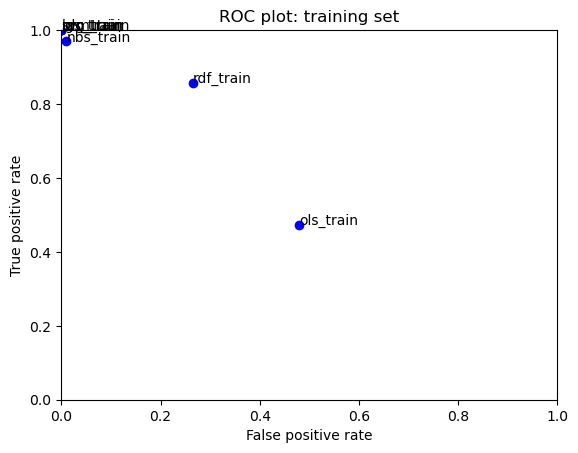

In [136]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## We can see that all models perform very well on the training data, except for the ols, nbs, and rdf models. 

## Let's run our test data on all our models to see if there's any difference. 

In [111]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2539, 'Neg': 2461, 'TP': 2152, 'TN': 2004, 'FP': 457, 'FN': 387, 'Accuracy': 0.8312, 'Precision': 0.8248371023380605, 'Recall': 0.8475777865301299, 'desc': 'rdg_test'}


In [112]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2539, 'Neg': 2461, 'TP': 1527, 'TN': 1112, 'FP': 1349, 'FN': 1012, 'Accuracy': 0.5278, 'Precision': 0.5309457579972183, 'Recall': 0.6014178810555336, 'desc': 'ols_test'}


In [113]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2539, 'Neg': 2461, 'TP': 2132, 'TN': 2049, 'FP': 412, 'FN': 407, 'Accuracy': 0.8362, 'Precision': 0.8380503144654088, 'Recall': 0.8397006695549429, 'desc': 'svm_test'}


In [114]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2539, 'Neg': 2461, 'TP': 2166, 'TN': 2033, 'FP': 428, 'FN': 373, 'Accuracy': 0.8398, 'Precision': 0.8350038550501157, 'Recall': 0.8530917684127609, 'desc': 'lgs_test'}


In [115]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2539, 'Neg': 2461, 'TP': 1913, 'TN': 1880, 'FP': 581, 'FN': 626, 'Accuracy': 0.7586, 'Precision': 0.7670408981555734, 'Recall': 0.7534462386766444, 'desc': 'nbs_test'}


In [116]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2539, 'Neg': 2461, 'TP': 2134, 'TN': 2041, 'FP': 420, 'FN': 405, 'Accuracy': 0.835, 'Precision': 0.8355520751761942, 'Recall': 0.8404883812524616, 'desc': 'prc_test'}


In [117]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2539, 'Neg': 2461, 'TP': 1856, 'TN': 2035, 'FP': 426, 'FN': 683, 'Accuracy': 0.7782, 'Precision': 0.813321647677476, 'Recall': 0.7309964552973611, 'desc': 'rdf_test'}


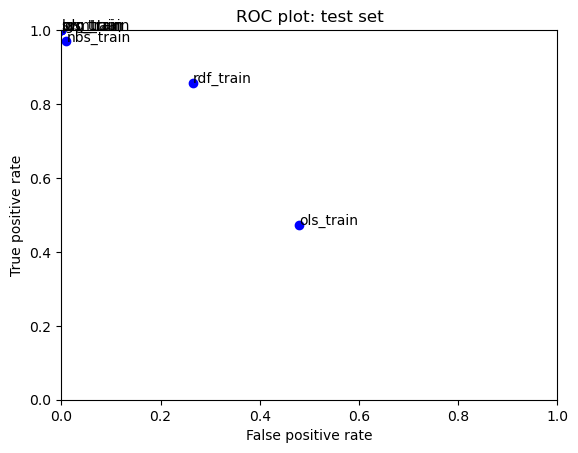

In [137]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## Again, we can see that all models perform very well on the test data, except for the ols and rdf models. 

In [144]:
# read in test data for submission
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=32, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of CountingVectorizer X:
(25000, 74849)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc_count_2
0         131           5             0
1         169          15             1
2         176          18             0
3         112           5             0
4         133           8             0
5         331          20             1
6         

## As our model, I chose Ridge Regression Classifier. Although it wasn't affecting the outcome by much, we wanted to see what accuracy we would get with the model we'd trained thus far. 

In [145]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49


In [146]:
raw_data.head()

,id,review,word_count,punc_count,punc_count_2
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0
4,12128_7,A very accurate depiction of small time mob li...,133,8,0


In [147]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [149]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)